## Multi-layer Perceptrons

In [ ]:
%matplotlib inline

import pdb
import numpy as np
import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
from scipy.optimize import fmin_cg

import warnings
warnings.filterwarnings('ignore')

## Neural net cost function with regularization

In [2]:
def nn_cost_function(nn_params, input_layer_size, hidden_layer_size,
                     num_labels, X, y, lam):
    # nn_cost_function Implements the neural network cost function for a two layer
    # neural network which performs classification
    #   J = nn_cost_function(nn_params, hidden_layer_size, num_labels,
    #   X, y, lambda) computes the cost and gradient of the neural network. The
    #   parameters for the neural network are "unrolled" into the vector
    #   nn_params and need to be converted back into the weight matrices.
    #
    #   The returned parameter grad should be a "unrolled" vector of the
    #   partial derivatives of the neural network.

    # Reshape nn_params back into the parameters theta1 and theta2
    # for our 2 hidden-layer neural network
    mid = hidden_layer_size * input_layer_size
    theta1 = np.reshape(nn_params[:mid], (hidden_layer_size, input_layer_size)) #25x401
    theta2 = np.reshape(nn_params[mid:], (num_labels, hidden_layer_size + 1)) #10x26
    
    J = 0
    num_samples = X.shape[0]

    # add bias to the input data
    bias = np.ones((num_samples, 1))
    X1 = np.concatenate((bias, X), axis=1)

    # forward propagate
    layer1 = sigmoid(theta1.dot(X1.T))
    bias = np.ones((1, layer1.shape[1]))
    layer2 = np.concatenate((bias, layer1), axis=0)
    output = sigmoid(theta2.dot(layer2))

    # reshape y to nn format, one hot encoding
    ynn = np.zeros((num_samples, num_labels))
    for i in range(num_samples):
        ynn[i, y[i] -1] = 1 # column 10 represents digit 0
    #end
    ynn = ynn.T
    
    # cost function - first without regularization
    J = (-1 / num_samples) * np.sum(np.sum( ynn * np.log(output) + (1 - ynn) * np.log(1 - output) ))
    
    # cost function - first with regularization
    sum_layer1 = np.sum(np.sum( theta1[:, 1:-1] **2 ))
    sum_layer2 = np.sum(np.sum( theta2[:, 1:-1] **2 ))
    reg = (lam / (2 * num_samples)) * (sum_layer1 + sum_layer2)
    J = J + reg

    return J
#end


## Neural net cost function gradient

In [9]:
def nn_cost_function_gradient(nn_params, input_layer_size, hidden_layer_size, 
                              num_labels, X, y, lam):
    # nn_cost_function Implements the neural network cost function for a two layer
    # neural network which performs classification
    #   grad = nn_cost_function(nn_params, hidden_layer_size, num_labels,
    #   X, y, lambda) computes the cost and gradient of the neural network. The
    #   parameters for the neural network are "unrolled" into the vector
    #   nn_params and need to be converted back into the weight matrices.
    #
    #   The returned parameter grad should be a "unrolled" vector of the
    #   partial derivatives of the neural network.

    # Reshape nn_params back into the parameters theta1 and theta2
    # for our 2 hidden-layer neural network

    mid = hidden_layer_size * input_layer_size
    theta1 = np.reshape(nn_params[:mid], (hidden_layer_size, input_layer_size)) #25x401
    theta2 = np.reshape(nn_params[mid:], (num_labels, hidden_layer_size + 1)) #10x26
    
    num_samples = X.shape[0]
    theta1_grad = np.zeros(theta1.shape)
    theta2_grad = np.zeros(theta2.shape)

    # add bias to the input data
    bias = np.ones((num_samples, 1))
    X1 = np.concatenate((bias, X), axis=1)
    
    # reshape y to nn format, one hot encoding
    ynn = np.zeros((num_samples, num_labels))
    for i in range(num_samples):
        ynn[i, y[i] -1] = 1 # column 10 represents digit 0
    #end
    ynn = ynn.T
    
    # backpropogation, calculation of gradients
    for t in range(num_samples):
        # step 1: forward propagate
        a1 = X1[t, :]
        z2 = theta1.dot(a1.T)
        a2 = sigmoid(z2)
        z2 = np.insert(z2, 0, 1) # need to account for the bias
        a2 = np.insert(a2, 0, 1) # need to account for the bias
        z3 = theta2.dot(a2.T)
        a3 = sigmoid(z3)

        # step 2: compute error
        delta3 = a3 - ynn[:, t]
        
        # step 3: back propagate error through activation function
        delta2 = (theta2.T.dot(delta3)) * sigmoid_gradient(z2)
        
        # step 4: update weights
        theta2_grad += np.outer(delta3, a2.T)
        theta1_grad += np.outer(delta2[1:], a1)
    # end
    
    # regularization
    theta1_tmp = np.copy(theta1)
    theta1_tmp[:, 0] = 0 # don't regularize bias terms
    theta1_grad = (theta1_grad + lam * theta1_tmp) / num_samples
    theta2_tmp = np.copy(theta2)
    theta2_tmp[:, 0] = 0
    theta2_grad = (theta2_grad + lam * theta2_tmp) / num_samples

    # unroll gradients
    theta1_flat = theta1_grad.flatten("F")
    theta2_flat = theta2_grad.flatten("F")
    grad = np.concatenate((theta1_flat, theta2_flat))
    
    return grad
# end


## Sigmoid function

In [4]:
def sigmoid(z):
    # sigmoid Compute sigmoid functoon
    # g = sigmoid(z) computes the sigmoid of z
    g = 1. / (1. + np.exp(-z))
    
    return g
# end


## Sigmoid gradient function

In [5]:
def sigmoid_gradient(z):
    # compute the gradient of the sigmoid function evaluated at
    # each value of z (z can be a matrix, vector or scalar)
    return sigmoid(z) * (1. - sigmoid(z))

## Classifying MNIST digits from pre-learned weights

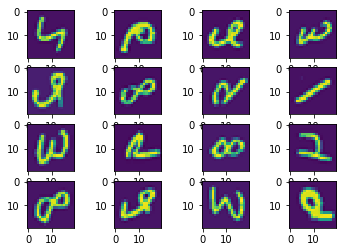

Loading saved neural network parameters ...

Training neural network... 

Cost without regularization: 0.2876 

> <ipython-input-7-d42b73bf5877>(67)nn_cost_function_gradient()
-> theta1_flat = theta1_grad.flatten("F")
(Pdb) n
> <ipython-input-7-d42b73bf5877>(68)nn_cost_function_gradient()
-> theta2_flat = theta2_grad.flatten("F")
(Pdb) theta1_flat[0:26]
array([ 6.18712766e-05,  9.38798109e-05, -1.92593606e-04, -1.68494568e-04,
        3.48682758e-04,  2.30505234e-04, -4.19602375e-05,  1.64744107e-05,
        3.42491549e-04, -2.09724069e-05, -5.41798089e-05, -1.54761646e-04,
       -7.12154786e-05, -2.25175106e-04,  1.11319389e-04, -3.70645529e-05,
       -2.36625362e-04,  1.13596508e-04,  1.84649925e-04,  1.51764569e-04,
        3.73892457e-04,  3.13986010e-04,  6.60569302e-05,  2.90522062e-04,
       -6.33753316e-05, -2.11248326e-12])
(Pdb) c
Cost with regularization: 0.3811 



In [8]:
# 5000 Mnist digits
data = loadmat('ex4data1.mat')
X = data['X']
y = data['y']

# 5000 samples, 500 from each class
n = X.shape[0]

# num of pixels per sample
d = X.shape[1]

# digits from 0 through 9
c = np.unique(y).size

# randomly select 16 image to display
fig = plt.figure()
for i in range(1, 17):
    index = np.random.randint(low=0, high=4999, size=1)
    image = np.reshape(X[index, :], (20, 20))
    fig.add_subplot(4, 4, i)
    plt.imshow(image)
# end
plt.show()

# load pre-learned weights
print('Loading saved neural network parameters ...\n')
weights = loadmat('ex4weights.mat')
theta1 = weights['Theta1']
theta2 = weights['Theta2']
weights_flat = np.concatenate((theta1.flatten(), theta2.flatten()))

# cost without regularization
print('Training neural network... \n')
lam = 0
J = nn_cost_function(weights_flat, theta1.shape[1], theta1.shape[0], c, X, y, lam)
print('Cost without regularization: %2.4f \n' % J)

# cost with regularization
lam = 1
J = nn_cost_function(weights_flat, theta1.shape[1], theta1.shape[0], c, X, y, lam)
grad = nn_cost_function_gradient(weights_flat, theta1.shape[1], theta1.shape[0], c, X, y, lam)
print('Cost with regularization: %2.4f \n' % J)


## Classifying MNIST digits from random weights

In [ ]:
def print_progress(theta):
    # callback function for fmin_cg to print out process
    global Nfeval
    print('{0:4d}   {1: 2.4f}'.format(Nfeval, nn_cost_function(theta, d+1, t, c, X, y, lam)))
    Nfeval += 1
# end

Nfeval = 1

# random number generator seed
np.random.seed(2000)

data = loadmat('ex4data1.mat')
X = data['X']
y = data['y']

# initializing random weights
print('initializing neural network parameters ...\n')
t = theta1.shape[0]
layer1_size = t * (d + 1) # 25x401
layer2_size = c * (t + 1) # 10x26
init_theta = np.random.rand(layer1_size + layer2_size, 1)

# group the arguments
args = (d+1, t, c, X, y, lam)

# start minimizing cost
print('Training neural network... \n')
print('{0:4s}   {1:9s}'.format(' Iter', ' Cost'))
theta_opt = fmin_cg(nn_cost_function, init_theta, nn_cost_function_gradient,
                    args=args, maxiter=50, callback=print_progress, disp=0)

# reshape the weights to correct sizes
theta1_opt = np.reshape(theta_opt[:layer1_size], (t, d + 1)) # 25x401
theta2_opt = np.reshape(theta_opt[layer1_size:], (c, t + 1)) # 10x26

# forward propagate
bias = np.ones((n, 1))
X1 = np.concatenate((bias, X), axis=1)
    
layer1 = sigmoid(theta1_opt.dot(X1.T))
bias = np.ones((1, layer1.shape[1]))
layer2 = np.concatenate((bias, layer1), axis=0)
output = sigmoid(theta2.dot(layer2))

# find out accuracy
predict = np.argmax(output, axis=0)
predict = predict.reshape(5000, 1)

# TODO: fix accuracy
acc = np.sum(predict == y) / n
print('Training set accuracy: %2.2f\n' % acc)


## Classifying MNIST digits with Tensorflow

In [ ]:
# 5000 Mnist digits 
data = loadmat('ex4data1.mat')
x_input = data['X']
y_truth = data['y']

# learning parameters
learning_rate = 0.001

# Network Parameters
n_sample = 5000
n_hidden = 25 
n_input = 400 # MNIST data input image: 20x20 pixels
n_class = 10 # 0 - 9 digits

# convert group truth digits to one-hot encoding
ynn = np.zeros((n_sample, n_class))
for i in range(n_sample):
    label = 0 if y_truth[i] == 10 else y_truth[i]
    ynn[i, label] = 1 # column 1 represents digit 0
#end

# TF inputs
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_class])

# hidden layer weights
h1 = tf.Variable(tf.random_normal([n_input, n_hidden]))
# hidden layer bias
bias1 = tf.Variable(tf.random_normal([n_hidden]))
# hidden layer output
hidden = tf.nn.sigmoid(tf.add(tf.matmul(X, h1), bias1))

# output layer weights
h2 = tf.Variable(tf.random_normal([n_hidden, n_class]))
# output layer bias
bias2 = tf.Variable(tf.random_normal([n_class]))
# output layer output
output = tf.nn.sigmoid(tf.add(tf.matmul(hidden, h2), bias2))

# cost function
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=Y))

# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# performance metrics
total_cost = 0
    
# running tf graph
init = tf.initialize_all_variables()
with tf.Session() as sess:
    sess.run(init)
    for i in range(n_sample):
        x = np.reshape(x_input[i, :], (1, n_input))
        y = np.reshape(ynn[i, :], (1, n_class))
        sess.run(optimizer, feed_dict={X: x, Y: y})
        total_cost += sess.run(cost, feed_dict={X: x, Y: y})
    # end
    avg_cost = total_cost / n_sample
    correct_pred = tf.equal(tf.argmax(output, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, "float"))
    print("Model Accuracy:", accuracy.eval({X: x_input, Y: ynn}))